# Personal Information
Name: **Anh Tran**

StudentID: **12770698**

Email: [**anh.tran1@student.uva.nl**](anh.tran1@student.uva.nl)

Submitted on: **DD.MM.YYYY**

# Data Context
**In this section you should introduce the datasources and datasets which you will be working with. Explain where they are from as well as their domain. Give an overview of what the context of the data is. You should not spend more than 1 to 2 paragraphs here as the core information will be in the next section.**

The topic of this research project is to explore gentrification - the process of a neighborhood changing as a result of wealthier residents moving in, bringing investments and physical improvements, but displacing existing residents as prices rise and cultures homogenized or replaced. This project examines the visual indicators of gentrification, more specifically in the signage of storefronts in Amsterdam, by applying computer vision methods on images of facades in the city.

The image dataset used in this project is from the [StreetSwipe project](http://streetswipe.aestheticsofexclusion.com/about.php). Via crowd-sourcing, the project let people decide which facade is gentrified, by voting "Yes" or "No" on the streetview images. The official *gentrified* and *non-gentrified* labels are generated based the majority of votes for each facade. Additionally, if subsequent voters decides against the majority, they are prompted to provide a textual explanation for their vote (mismatch responses).

On this data, scene-text detection will be applied to identify the region of the images that contain storefront signage. With the text region extracted (still as an image), font recognition and color extraction will be done to understand these attributes; and text recognition will be applied to extract machine-readable text strings, whose semantic meanings will be studied using word embedding. This pipeline will be applied on gentrified and non-gentrified labelled subsets of the data, and ultimately the learnt attributes (fonts, colors, semantics) of these classes are compared to understand what is seen as gentrified.

# Data Description

**Present here the results of your exploratory data analysis. Note that there is no need to have a "story line" - it is more important that you show your understanding of the data and the methods that you will be using in your experiments (i.e. your methodology).**

**As an example, you could show data, label, or group balances, skewness, and basic characterizations of the data. Information about data frequency and distributions as well as results from reduction mechanisms such as PCA could be useful. Furthermore, indicate outliers and how/why you are taking them out of your samples, if you do so.**

**The idea is, that you conduct this analysis to a) understand the data better but b) also to verify the shapes of the distributions and whether they meet the assumptions of the methods that you will attempt to use. Finally, make good use of images, diagrams, and tables to showcase what information you have extracted from your data.**

As you can see, you are in a jupyter notebook environment here. This means that you should focus little on writing text and more on actually exploring your data. If you need to, you can use the amsmath environment in-line: $e=mc^2$ or also in separate equations such as here:

\begin{equation}
    e=mc^2 \mathrm{\space where \space} e,m,c\in \mathbb{R}
\end{equation}

Furthermore, you can insert images such as your data aggregation diagrams like this:

<!-- ![image](example.png) -->

In [2]:
# Imports
import os, sys
import numpy as np
import pandas as pd
from glob import glob
# from bq_helper import BigQueryHelper
from dask import bag, diagnostics 
from urllib import request
import cv2
import glob
import missingno as msno
import hvplot.pandas  # custom install
from matplotlib import pyplot as plt
%matplotlib inline

#### Data Loading

The data is divided into two subsets, generally called pre-July 2020 and post-July 2020. This is because there are two versions of the StreetSwipe data collection tool. All in all,there are 2441 images in total - 1912 images in the older version and 529 in the new one. While the images from the pre-July 2020 subset are available directly, those from the new version are stored in a Google APIs bucket - these were scraped via the URLs provided. Each image has metadata on the facade's location (latitude and longitude) and street name. The new version images also have more detailed address, name and type of business/services. 

In terms of data generated from StreetSwipe's tool, these are stored in multiple CSV files. All images have corresponding data entries on the numbers of "yes" and "no" votes for gentrification. In addition, each individual response is recorded with an unique response ID, along with the image ID, the vote (yes/no), *[...]*. Lastly, mismatch responses are also recorded with an unique response ID, image ID, the vote (yes/no), and the textual answer given by the voter.

Since the main interest of the research is to learn visual patterns from the labeled facades, the data that will be further processed and discussed in this analysis consists only of the images and the CSV files with votes for each image. These data are loaded below, divided into the pre- and post-July 2020 subsets.

In [2]:
scores_pre = pd.read_csv("database/pre_202007/ss_afb_scores.csv", names = ['id','vote1','vote2'] )
scores_post = pd.read_csv("database/post_202007/ss_afb_scores.csv", names = ['id','vote1','vote2'] )
                        
print(f"Number of rows old version: {len(scores_pre)}")
print(f"Number of rows new version: {len(scores_post)}")

Number of rows old version: 1912
Number of rows new version: 531


In [3]:
images = [cv2.imread(file) for file in glob.glob("all_images/*.jpg")]
print(f"Total number of images: {len(images)}")
# cv2.imshow("Samples", images[np.random.randint(10)])
# cv2.waitKey(0)
# cv2.destroyAllWindows()

Total number of images: 2441


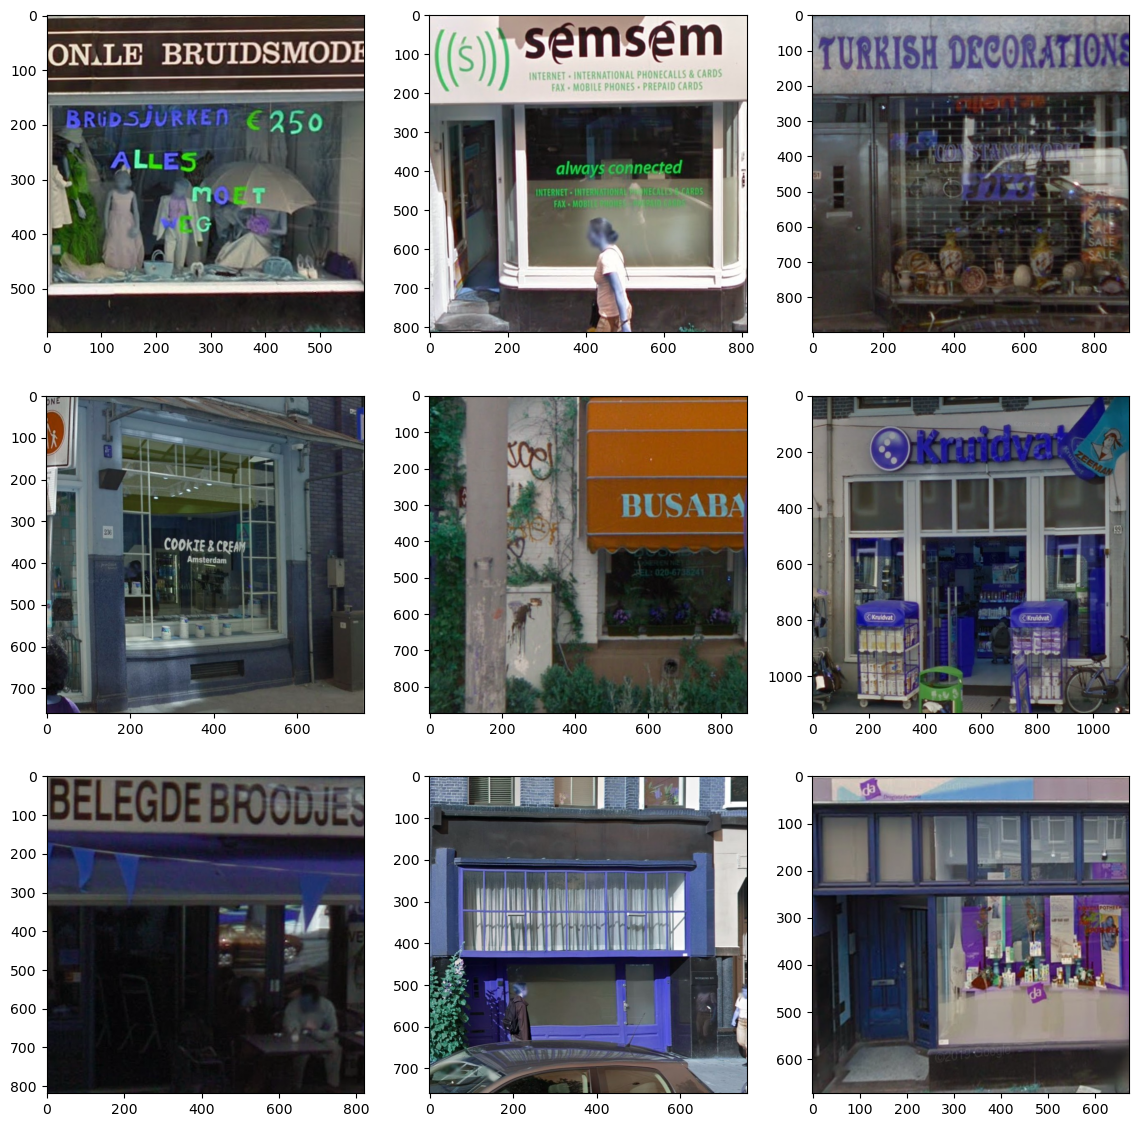

In [5]:
sample_img = [images[i] for i in np.random.randint(2441, size =(9))]

fig = plt.figure(figsize=(14,14))
rows, cols = 3, 3

# Display 12 random images
for i in range(0, cols*rows):
  fig.add_subplot(rows, cols, i+1)
  plt.imshow(sample_img[i])
plt.show()

### Labels
Below is an overview into the original shape of the main data frames of interest - ones that indicate the number of gentrified/non-gentrified votes per image. As can be seen, there are more votes in the post-July 2020 version *(scores_post)* than in the older version *(scores_pre)*

In [5]:
print(scores_pre.head())
print(scores_post.head())

   id  vote1  vote2
0   1      0      3
1   2      0      2
2   3      0      1
3   4      0      3
4   5      0      4
                               id  vote1  vote2
0  faillissementsdossier:24368214      0      1
1  faillissementsdossier:33251073      5     74
2  faillissementsdossier:60624485      0     20
3  faillissementsdossier:63432250     34     56
4  faillissementsdossier:63453428     66      9


### Images: 

#### Specs
* Size/Dimensions
* Aspect ratios (width/height)
* Avg width and height
* Resolution
* Colors

In relation to models' img size requirements

In the new version, all images have size 760x760, while those in the old version vary in sizes. Additionally, images in the older version has higher-resolution images. *[How to deal with this in modeling??]*

#### Visual analysis
Noted that there are plenty of instances where non-gentrified facades contain no signage - something that can be directly concluded.

In [3]:
# Also don't forget to comment your code
# This way it's also easier to spot thought errors along the way

#### Sample size per class